In [ ]:

pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=bc7d613f324de352b81132b31b97f2dab3e2ec9647c2b65eeefa2fc14712a0fe
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
pip install sentence_transformers

In [ ]:
pip install nltk

In [ ]:
import pandas as pd
import re
import statistics


file_path = 'responses.csv'
data = pd.read_csv(file_path)

questions = []
for i in range(0, len(data.columns) - 1):
    column = data.iloc[:, i]

    header_text = column.name
    parts = [part.strip() for part in header_text.split("\n") if part.strip()]

    question = None
    model_response = []
    expected_answer = []
    mode = None

    for part in parts:
        if part.startswith("Question:"):
            question = part.replace("Question: ", "").strip()
        elif part.startswith("Model's Response:"):
            mode = "model_response"
            model_response.append(part.replace("Model's Response:", "").strip())
        elif part.startswith("Expected Ideal Answer:"):
            mode = "expected_answer"
            expected_answer.append(part.replace("Expected Ideal Answer:", "").strip())
        else:
            if mode == "model_response":
                model_response.append(part)
            elif mode == "expected_answer":
                expected_answer.append(part)

    model_response = " ".join(model_response).strip()
    expected_answer = " ".join(expected_answer).strip()


    evaluation_numbers = column.tolist()

    question_dict = {
        "Question": question,
        "Model Response": model_response,
        "Expected Answer": expected_answer,
        "Evaluation Numbers": evaluation_numbers,
        "Mean" : statistics.mean(evaluation_numbers),
        "Mode" : statistics.mode(evaluation_numbers)
    }

    questions.append(question_dict)

In [ ]:
questions[:2]

[{'Question': 'What are the primary symptoms of coronary heart disease (CHD)?',
  'Model Response': "Coronary heart disease (CHD) can present with a variety of symptoms, especially in older adults. Some common symptoms to watch out for include chest pain or discomfort (angina), shortness of breath, fatigue, weakness, and even sudden dizziness or fainting. It's important to note that some individuals may not experience any symptoms at all, which is why regular check-ups with your healthcare provider are crucial. If you ever have concerns about your heart health or experience any of these symptoms, please seek medical attention promptly to ensure your well-being and heart health.",
  'Expected Answer': 'The primary symptoms of coronary heart disease are chest pain (angina) and breathlessness. Angina is often a mild, uncomfortable feeling, but can become severe and spread to other areas such as the arms, neck, jaw, back, or stomach. In some cases, CHD may not show any symptoms before diag

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score

model_st = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('punkt')



def cosine_similarity_score(response, expected):
    vectorizer = TfidfVectorizer().fit_transform([response, expected])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]

def sentence_bert_score(response, expected):
    embeddings = model_st.encode([response, expected])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

def bleu_score(response, expected):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([expected.split()], response.split(), weights=(0.5, 0.5), smoothing_function=smoothie)

def rouge_score(response, expected):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(expected, response)
    return scores['rouge1'].fmeasure

def token_overlap_score(response, expected):
    response_tokens = set(word_tokenize(response.lower()))
    expected_tokens = set(word_tokenize(expected.lower()))
    overlap = response_tokens.intersection(expected_tokens)
    return len(overlap) / len(expected_tokens)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embedding_similarity(response, expected):

    response_inputs = tokenizer(response, return_tensors='pt', truncation=True, max_length=512)
    expected_inputs = tokenizer(expected, return_tensors='pt', truncation=True, max_length=512)

    with torch.no_grad():
        response_outputs = model(**response_inputs)
        expected_outputs = model(**expected_inputs)

    response_embedding = response_outputs.last_hidden_state[:, 0, :].numpy()
    expected_embedding = expected_outputs.last_hidden_state[:, 0, :].numpy()

    similarity = cosine_similarity(response_embedding, expected_embedding)
    return similarity[0][0]

def calculate_meteor_score(response, expected):
    response, expected = response.split(), expected.split()
    return nltk.translate.meteor_score.meteor_score([expected],response)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def calculate_metrics(entry):
    response = entry['Model Response']
    expected = entry['Expected Answer']


    metrics = {
        'Cosine Similarity': cosine_similarity_score(response, expected),
        'Sentence-BERT Similarity': sentence_bert_score(response, expected),
        'BLEU Score': bleu_score(response, expected),
        'ROUGE Score': rouge_score(response, expected),
        'METEOR Score': calculate_meteor_score(response, expected),
        'BERT Embedding Cosine Similarity': bert_embedding_similarity(response, expected),
        'Token Overlap': token_overlap_score(response, expected),
        'Human Mean Evaluation': entry['Mean']
    }

    return metrics

results = [calculate_metrics(entry) for entry in questions]

df_results = pd.DataFrame(results)

df_results

Cosine Similarity  Sentence-BERT Similarity  BLEU Score  ROUGE Score  \
0            0.308681                  0.896224    0.096331     0.321678   
1            0.375964                  0.901540    0.137094     0.479339   
2            0.425426                  0.832945    0.068706     0.335878   
3            0.187777                  0.728107    0.058277     0.190000   
4            0.418838                  0.779699    0.045501     0.295820   
5            0.469273                  0.885470    0.190430     0.420382   
6            0.380081                  0.774026    0.299050     0.470588   
7            0.326527                  0.699176    0.102288     0.360360   
8            0.553250                  0.823865    0.174715     0.441281   
9            0.188336                  0.647923    0.083042     0.280374   
10           0.400204                  0.707197    0.174040     0.394366   

    METEOR Score  BERT Embedding Cosine Similarity  Token Overlap  \
0       0.258187                          0.773342       0.510204   
1       0.230426                          0.956991       0.370968   
2       0.376405                          0.913601       0.634615   
3       0.187280                          0.872549       0.354167   
4       0.215840                          0.834744       0.373494   
5       0.360832                          0.894332       0.452830   
6       0.470555                          0.907456       0.629630   
7       0.339466                          0.948898       0.500000   
8       0.304540                          0.889120       0.458824   
9       0.146024                          0.813596       0.296296   
10      0.257551                          0.900846       0.413793   

    Human Mean Evaluation  
0                   4.125  
1                   3.875  
2                   3.875  
3                   2.750  
4                   4.000  
5                   3.625  
6                   3.250  
7                   3.125  
8                   3.875  
9                   3.625  
10                  3.250

# Rescale of metrics


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


objective_metrics = [
    'Cosine Similarity', 'Sentence-BERT Similarity', 'BLEU Score',
    'ROUGE Score', 'METEOR Score', 'BERT Embedding Cosine Similarity',
    'Token Overlap']

scaler = MinMaxScaler(feature_range=(1, 5))
df_rescaled = df_results.copy()
df_rescaled[objective_metrics] = scaler.fit_transform(df_results[objective_metrics])


correlations = df_rescaled[objective_metrics].corrwith(df_results['Human Mean Evaluation'])


print("Correlation of each metric with Human Mean Evaluation:")
print(correlations)


best_metric = correlations.idxmax()
best_correlation = correlations.max()

print(f"\nThe metric with the highest correlation to human evaluation is: {best_metric} with a correlation of {best_correlation:.4f}")


Correlation of each metric with Human Mean Evaluation:
Cosine Similarity                   0.449221
Sentence-BERT Similarity            0.622076
BLEU Score                         -0.167778
ROUGE Score                         0.251830
METEOR Score                       -0.062995
BERT Embedding Cosine Similarity   -0.355160
Token Overlap                       0.079203
dtype: float64

The metric with the highest correlation to human evaluation is: Sentence-BERT Similarity with a correlation of 0.6221


<ipython-input-33-84f974ddde7e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette="viridis", width=0.5)


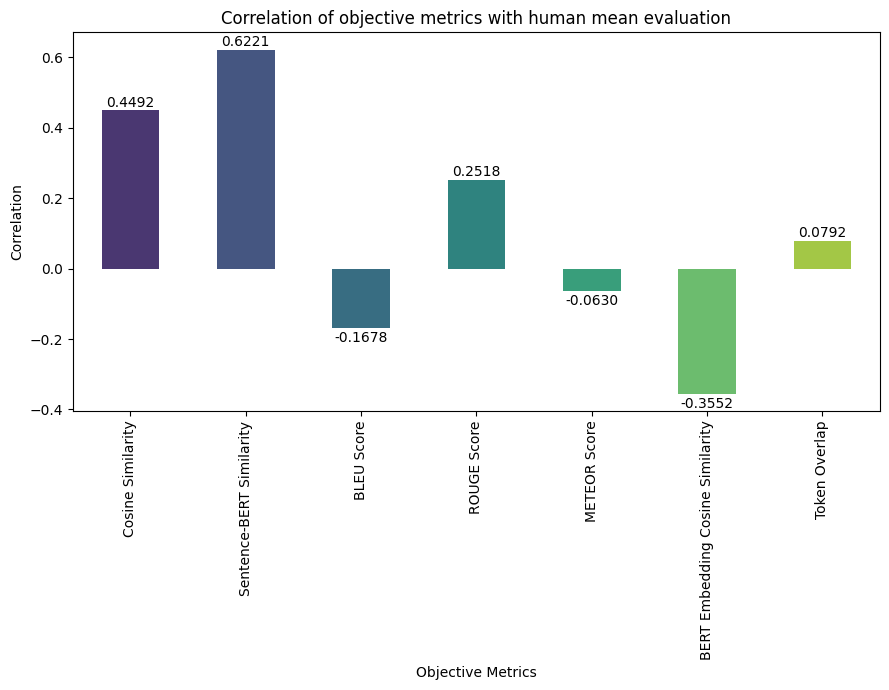

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot
plt.figure(figsize=(9, 7))
sns.barplot(x=correlations.index, y=correlations.values, palette="viridis", width=0.5)

# Add the correlation values on top of each bar
for i, value in enumerate(correlations.values):
  if value > 0:
    plt.text(i, value + 0.01, f"{value:.4f}", ha='center', fontsize=10)
  else:
    plt.text(i, value - 0.04, f"{value:.4f}", ha='center', fontsize=10)


# Customize the plot
plt.title('Correlation of objective metrics with human mean evaluation')
plt.xlabel('Objective Metrics')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_results.to_csv('results.csv', index = False)
df_rescaled.to_csv('rescaled_metrics.csv', index=False)

# Model evaluation

Now that we know which is the best metric, we can evaluate the other models and compare.

In [ ]:
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


model_st = SentenceTransformer('all-MiniLM-L6-v2')

def clean_text(text):
    cleaned_text = re.sub(r'[\n*]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def sentence_bert_score(response, expected):
    expected = clean_text(expected)
    response = clean_text(response)
    embeddings = model_st.encode([response, expected])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]


json_files = ['/content/gemma-7b-it_results.json', '/content/mixtral-8x7b-32768_results.json', '/content/llama-3.1-8b-instant_results.json', '/content/gpt-4o_results.json', '/content/gpt-3.5-turbo_results.json','/content/llama-3.1-70b-versatile_results.json']  # Add your file paths here
results = {}


In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)

    similarities = []
    for entry in data:
        expected_answer = entry['Expected Answer']
        model_response = entry['Model Response']
        similarity = sentence_bert_score(model_response, expected_answer)
        similarities.append(similarity)

    # Calculate statistics
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    min_similarity = np.min(similarities)
    max_similarity = np.max(similarities)
    median_similarity = np.median(similarities)

    # Store the statistics
    results[json_file] = {
        "mean": avg_similarity,
        "std": std_similarity,
        "min": min_similarity,
        "max": max_similarity,
        "median": median_similarity
    }


print("Similarity Statistics per Model:")
for model_name, stats in results.items():
    print(f"{model_name}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value:.4f}")
    print()


Similarity Statistics per Model:
/content/gemma-7b-it_results.json:
  mean: 0.6569
  std: 0.2100
  min: 0.2732
  max: 0.9153
  median: 0.7865

/content/mixtral-8x7b-32768_results.json:
  mean: 0.7275
  std: 0.1475
  min: 0.4815
  max: 0.9031
  median: 0.8080

/content/llama-3.1-8b-instant_results.json:
  mean: 0.7406
  std: 0.1342
  min: 0.4638
  max: 0.8753
  median: 0.7984

/content/gpt-4o_results.json:
  mean: 0.7826
  std: 0.0915
  min: 0.6056
  max: 0.8785
  median: 0.8312

/content/gpt-3.5-turbo_results.json:
  mean: 0.7887
  std: 0.0827
  min: 0.6479
  max: 0.9015
  median: 0.7797

/content/llama-3.1-70b-versatile_results.json:
  mean: 0.3312
  std: 0.3792
  min: -0.0662
  max: 0.8210
  median: 0.0423



In [ ]:
best_model = max(results, key=lambda x: results[x]["mean"])
print(f"\nBest Model: {best_model} with a mean similarity of {results[best_model]['mean']:.4f}\n")


Best Model: /content/gpt-3.5-turbo_results.json with a mean similarity of 0.7887



In [ ]:
import pandas as pd
import os
model_names = list(results.keys())
means = [results[model]["mean"] for model in model_names]
stds = [results[model]["std"] for model in model_names]
mins = [results[model]["min"] for model in model_names]
maxs = [results[model]["max"] for model in model_names]
medians = [results[model]["median"] for model in model_names]


model_names = [os.path.splitext(os.path.basename(model))[0].replace('_results', '') for model in results.keys()]
data = {
    "Model": model_names,
    "Mean Similarity": means,
    "Standard Deviation": stds,
    "Min Similarity": mins,
    "Max Similarity": maxs,
    "Median Similarity": medians
}

df = pd.DataFrame(data)

plt.figure(figsize=(14, 8))


def add_percentages(ax, values):
    for i, v in enumerate(values):
      if v> 0:
        ax.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)
      else:
        ax.text(i, v - 0.03, f"{v:.2%}", ha='center', fontsize=10)

<Figure size 1400x800 with 0 Axes>

In [ ]:
df

Model  Mean Similarity  Standard Deviation  \
0              gemma-7b-it         0.656898            0.209998   
1       mixtral-8x7b-32768         0.727511            0.147521   
2     llama-3.1-8b-instant         0.740624            0.134213   
3                   gpt-4o         0.782621            0.091509   
4            gpt-3.5-turbo         0.788743            0.082735   
5  llama-3.1-70b-versatile         0.331185            0.379151   

   Min Similarity  Max Similarity  Median Similarity  
0        0.273203        0.915328           0.786536  
1        0.481504        0.903114           0.807952  
2        0.463771        0.875328           0.798355  
3        0.605626        0.878547           0.831157  
4        0.647923        0.901540           0.779699  
5       -0.066203        0.820996           0.042338

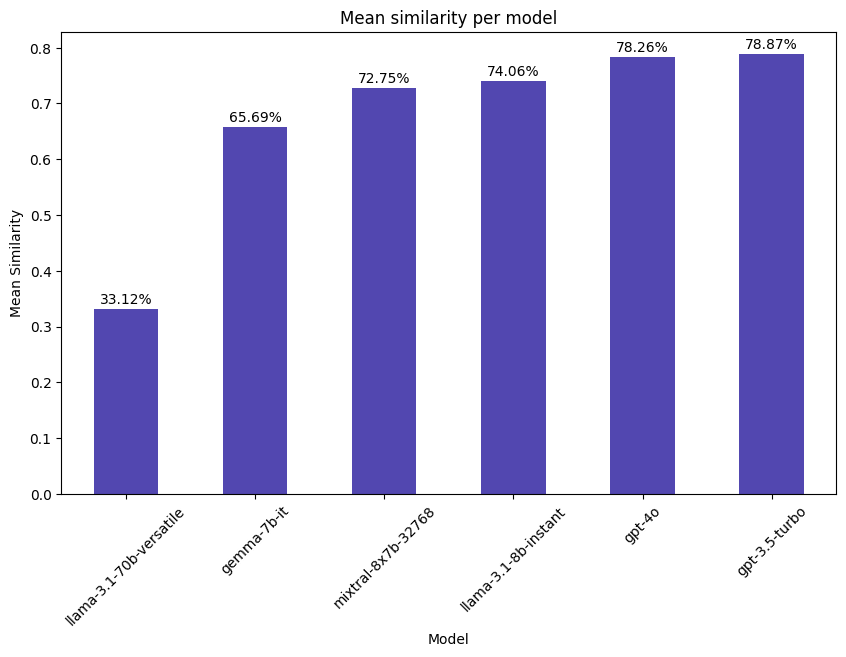

In [ ]:
# Mean Similarity
df_sorted_mean = df.sort_values(by="Mean Similarity")
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Mean Similarity", data=df_sorted_mean, width = 0.5, color = '#4535C1')
plt.title("Mean similarity per model")
plt.xticks(rotation=45)
add_percentages(plt.gca(), df_sorted_mean["Mean Similarity"])
plt.show()

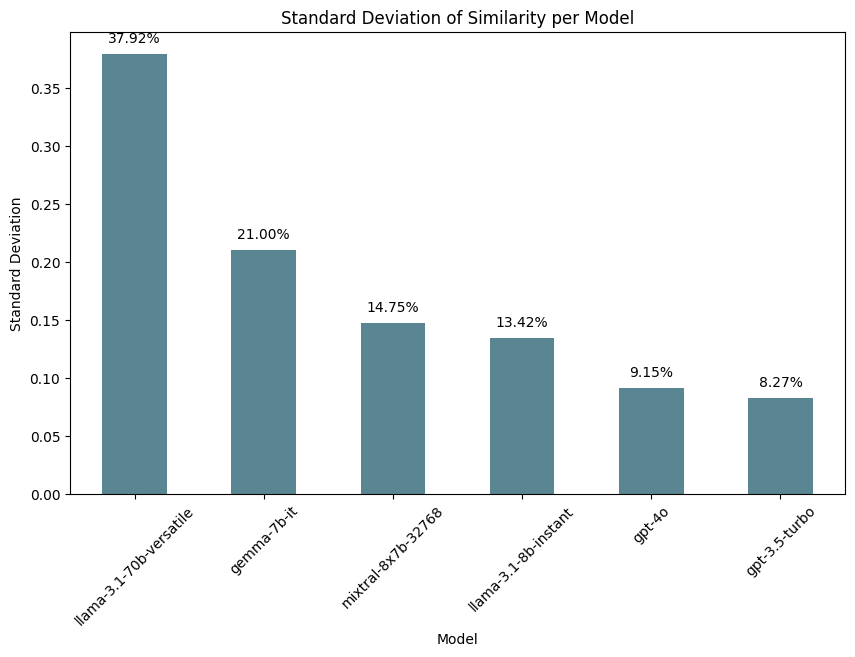

In [ ]:
# Standard Deviation
df_sorted_std = df.sort_values(by="Standard Deviation", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Standard Deviation", data=df_sorted_std, color='#508C9B', width=0.5)
plt.title("Standard Deviation of Similarity per Model")
plt.xticks(rotation=45)
add_percentages(plt.gca(), df_sorted_std["Standard Deviation"])
plt.show()


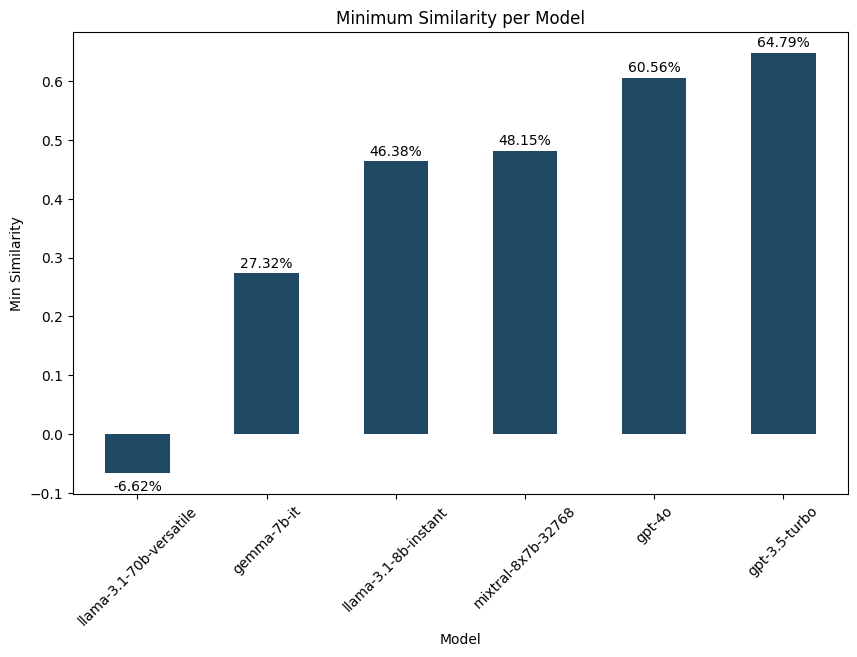

In [ ]:
# Sort the DataFrame by "Min Similarity" in ascending order
df_sorted_min = df.sort_values(by="Min Similarity")


# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Min Similarity", data=df_sorted_min, color='#134B70', width=0.5)
plt.title("Minimum Similarity per Model")
plt.xticks(rotation=45)
add_percentages(plt.gca(), df_sorted_min["Min Similarity"])
plt.show()

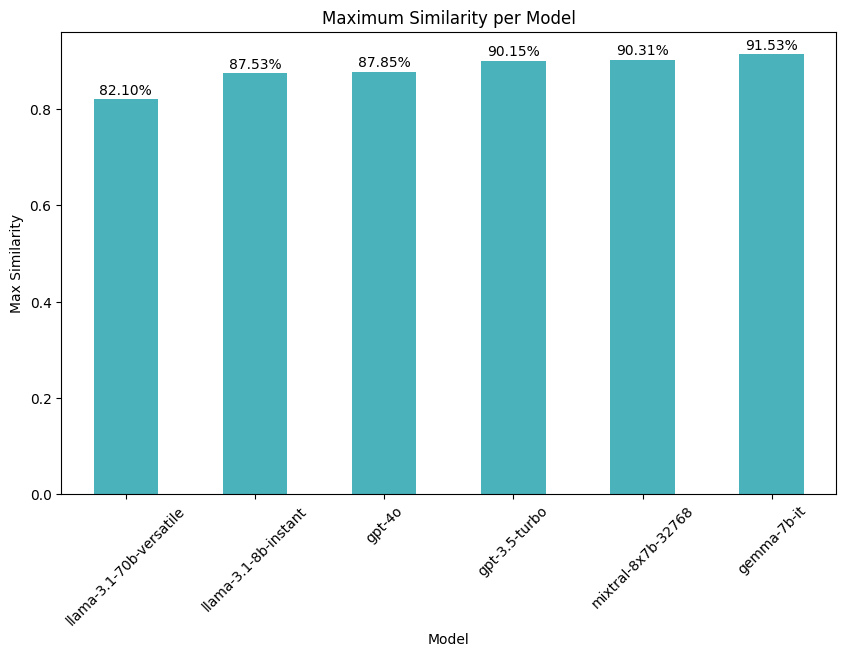

'\n# Max Similarity\nplt.figure(figsize=(10, 6))\nsns.barplot(x="Model", y="Max Similarity", data=df, width = 0.5, color = \'#36C2CE\')\nplt.title("Maximum Similarity per Model")\nplt.xticks(rotation=45)\nadd_percentages(plt.gca(), df["Max Similarity"])\nplt.show()\n'

In [ ]:
df_sorted_max = df.sort_values(by="Max Similarity")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Max Similarity", data=df_sorted, width=0.5, color='#36C2CE')
plt.title("Maximum Similarity per Model")
plt.xticks(rotation=45)
add_percentages(plt.gca(), df_sorted_max["Max Similarity"])
plt.show()
'''
# Max Similarity
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Max Similarity", data=df, width = 0.5, color = '#36C2CE')
plt.title("Maximum Similarity per Model")
plt.xticks(rotation=45)
add_percentages(plt.gca(), df["Max Similarity"])
plt.show()
'''

In [ ]:
df

Model  Mean Similarity  Standard Deviation  \
0              gemma-7b-it         0.656898            0.209998   
1       mixtral-8x7b-32768         0.727511            0.147521   
2     llama-3.1-8b-instant         0.740624            0.134213   
3                   gpt-4o         0.782621            0.091509   
4            gpt-3.5-turbo         0.788743            0.082735   
5  llama-3.1-70b-versatile         0.331185            0.379151   

   Min Similarity  Max Similarity  Median Similarity  
0        0.273203        0.915328           0.786536  
1        0.481504        0.903114           0.807952  
2        0.463771        0.875328           0.798355  
3        0.605626        0.878547           0.831157  
4        0.647923        0.901540           0.779699  
5       -0.066203        0.820996           0.042338

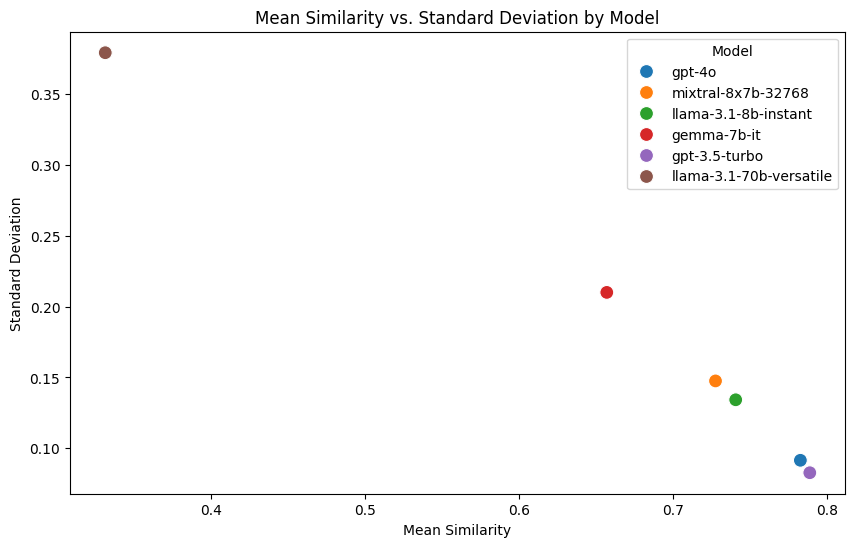

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Mean Similarity", y="Standard Deviation", hue="Model", data=df, s=100)
plt.title("Mean Similarity vs. Standard Deviation by Model")
plt.show()

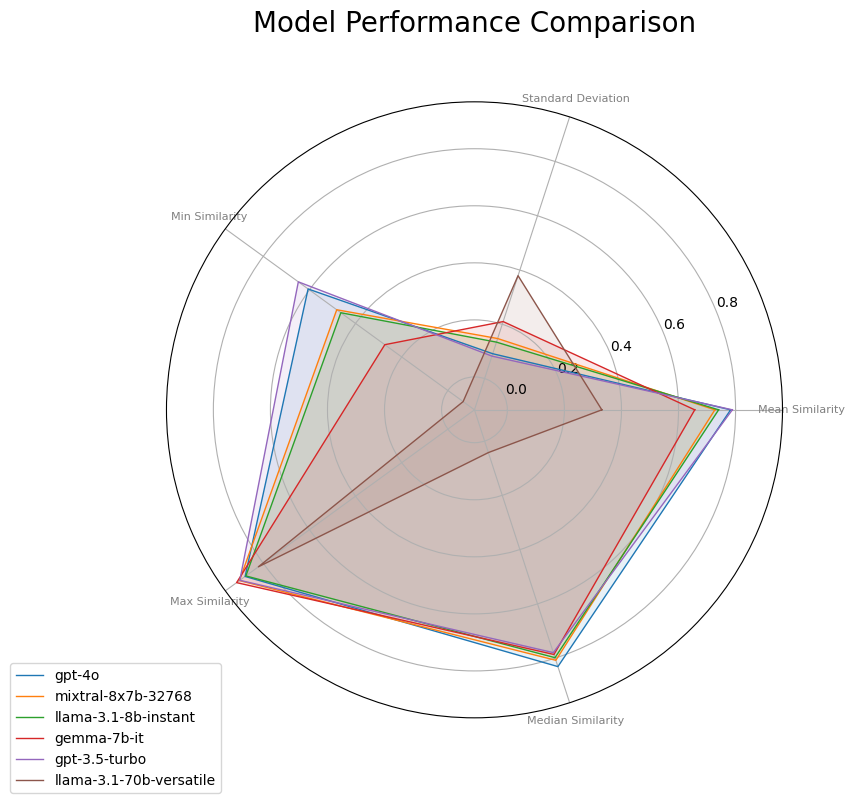

In [ ]:
import numpy as np
from math import pi

categories = list(df.columns[1:])
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for i, row in df.iterrows():
    values = row[1:].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories, color='grey', size=8)
plt.title('Model Performance Comparison', size=20, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()
